In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score

In [2]:
data = pd.read_csv('final.csv') 


In [3]:
data = data.dropna()

In [4]:
X = data.drop(['MB'], axis=1)  
y = data['MB']  

In [5]:
y_svm = 2 * y - 1


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_svm, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)


In [7]:
y_train_binary = (y_train + 1) // 2

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_binary)
y_train_resampled_mapped = 2 * y_train_resampled - 1

In [9]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
sample_weights = np.where(y_train_resampled == 0, class_weights[0], class_weights[1])

In [10]:
class LinearSVM(tf.keras.Model):
    def __init__(self, input_dim):
        super(LinearSVM, self).__init__()
        self.dense = tf.keras.layers.Dense(1, kernel_initializer='zeros', activation=None)

    def call(self, inputs):
        return self.dense(inputs)

In [11]:
def hinge_loss(y_true, y_pred):
    return tf.reduce_mean(tf.maximum(0.0, 1 - y_true * y_pred))

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation=None)
])

In [13]:
model.compile(
    optimizer='adam', 
    metrics=[tf.keras.metrics.AUC()],
    loss=hinge_loss
)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping( monitor='val_loss', patience=10, restore_best_weights=True)

In [15]:
history = model.fit(
    X_train_resampled, 
    y_train_resampled_mapped, 
    sample_weight=sample_weights,  
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping],
    verbose=0
)

In [16]:
y_pred = model.evaluate(X_test)

41/41 [==============================] - 0s 274us/step - loss: 0.0000e+00 - auc: 0.0000e+00


In [17]:
print("Training Metrics:")
y_train_pred = model.predict(X_train)
y_train_pred_labels = (y_train_pred > 0).astype(int).flatten()
y_train_pred_labels = 2 * y_train_pred_labels - 1 

Training Metrics:
143/143 [==============================] - 0s 189us/step


In [18]:
train_loss = hinge_loss(y_train_pred_labels, y_train_pred).numpy()
print(f"Loss: {train_loss:.4f}")

train_accuracy = accuracy_score(y_train, y_train_pred_labels)
print(f"Accuracy: {train_accuracy:.4f}")

train_auc = roc_auc_score(y_train, y_train_pred)
print(f"AUC: {train_auc:.4f}")

train_cm = confusion_matrix(y_train, y_train_pred_labels)
tn, fp, fn, tp = train_cm.ravel()
train_sensitivity = tp / (tp + fn)
train_specificity = tn / (tn + fp)
print(f"Sensitivity: {train_sensitivity:.4f}")
print(f"Specificity: {train_specificity:.4f}")

train_f1 = f1_score(y_train, y_train_pred_labels)
print(f"F1 Score: {train_f1:.4f}")

Loss: 1.1951
Accuracy: 0.9701
AUC: 0.9974
Sensitivity: 0.9887
Specificity: 0.9672
F1 Score: 0.8999


In [19]:
print("\nValidation Metrics:")
y_val_pred = model.predict(X_val)
y_val_pred_labels = (y_val_pred > 0).astype(int).flatten() 
y_val_pred_labels = 2 * y_val_pred_labels - 1 

val_loss = hinge_loss(y_val_pred_labels, y_val_pred).numpy()
print(f"Loss: {val_loss:.4f}")
val_accuracy = accuracy_score(y_val, y_val_pred_labels)
print(f"Accuracy: {val_accuracy:.4f}")

val_auc = roc_auc_score(y_val, y_val_pred)
print(f"AUC: {val_auc:.4f}")

val_cm = confusion_matrix(y_val, y_val_pred_labels)
tn, fp, fn, tp = val_cm.ravel()
val_sensitivity = tp / (tp + fn)
val_specificity = tn / (tn + fp)
print(f"Sensitivity: {val_sensitivity:.4f}")
print(f"Specificity: {val_specificity:.4f}")

val_f1 = f1_score(y_val, y_val_pred_labels)
print(f"F1 Score: {val_f1:.4f}")


Validation Metrics:
21/21 [==============================] - 0s 272us/step
Loss: 1.1077
Accuracy: 0.9785
AUC: 0.9953
Sensitivity: 0.9762
Specificity: 0.9788
F1 Score: 0.9213


In [20]:
print("\nTest Metrics:")
y_test_pred = model.predict(X_test)
y_test_pred_labels = (y_test_pred > 0).astype(int).flatten()
y_test_pred_labels = 2 * y_test_pred_labels - 1 

test_loss = hinge_loss (y_test_pred_labels, y_test_pred).numpy()
print(f"Loss: {test_loss:.4f}")

# Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_labels)
print(f"Accuracy: {test_accuracy:.4f}")

# AUC
test_auc = roc_auc_score(y_test, y_test_pred)
print(f"AUC: {test_auc:.4f}")

# Confusion Matrix for Sensitivity and Specificity
test_cm = confusion_matrix(y_test, y_test_pred_labels)
tn, fp, fn, tp = test_cm.ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)
print(f"Sensitivity: {test_sensitivity:.4f}")
print(f"Specificity: {test_specificity:.4f}")

# F1 Score
test_f1 = f1_score(y_test, y_test_pred_labels)
print(f"F1 Score: {test_f1:.4f}")


Test Metrics:
41/41 [==============================] - 0s 219us/step
Loss: 1.2302
Accuracy: 0.9577
AUC: 0.9940
Sensitivity: 0.9760
Specificity: 0.9550
F1 Score: 0.8556


In [21]:
import shap

In [22]:
background_data = shap.kmeans(X_train, 10)  # Use 10 clusters, adjust as necessary
explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test)

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/1301 [00:00<?, ?it/s]

685/685 [==============================] - 0s 517us/step


In [23]:
shap_values_reshaped = np.squeeze(shap_values)  # Removes the last dimension
print(shap_values_reshaped.shape)

(1301, 81)


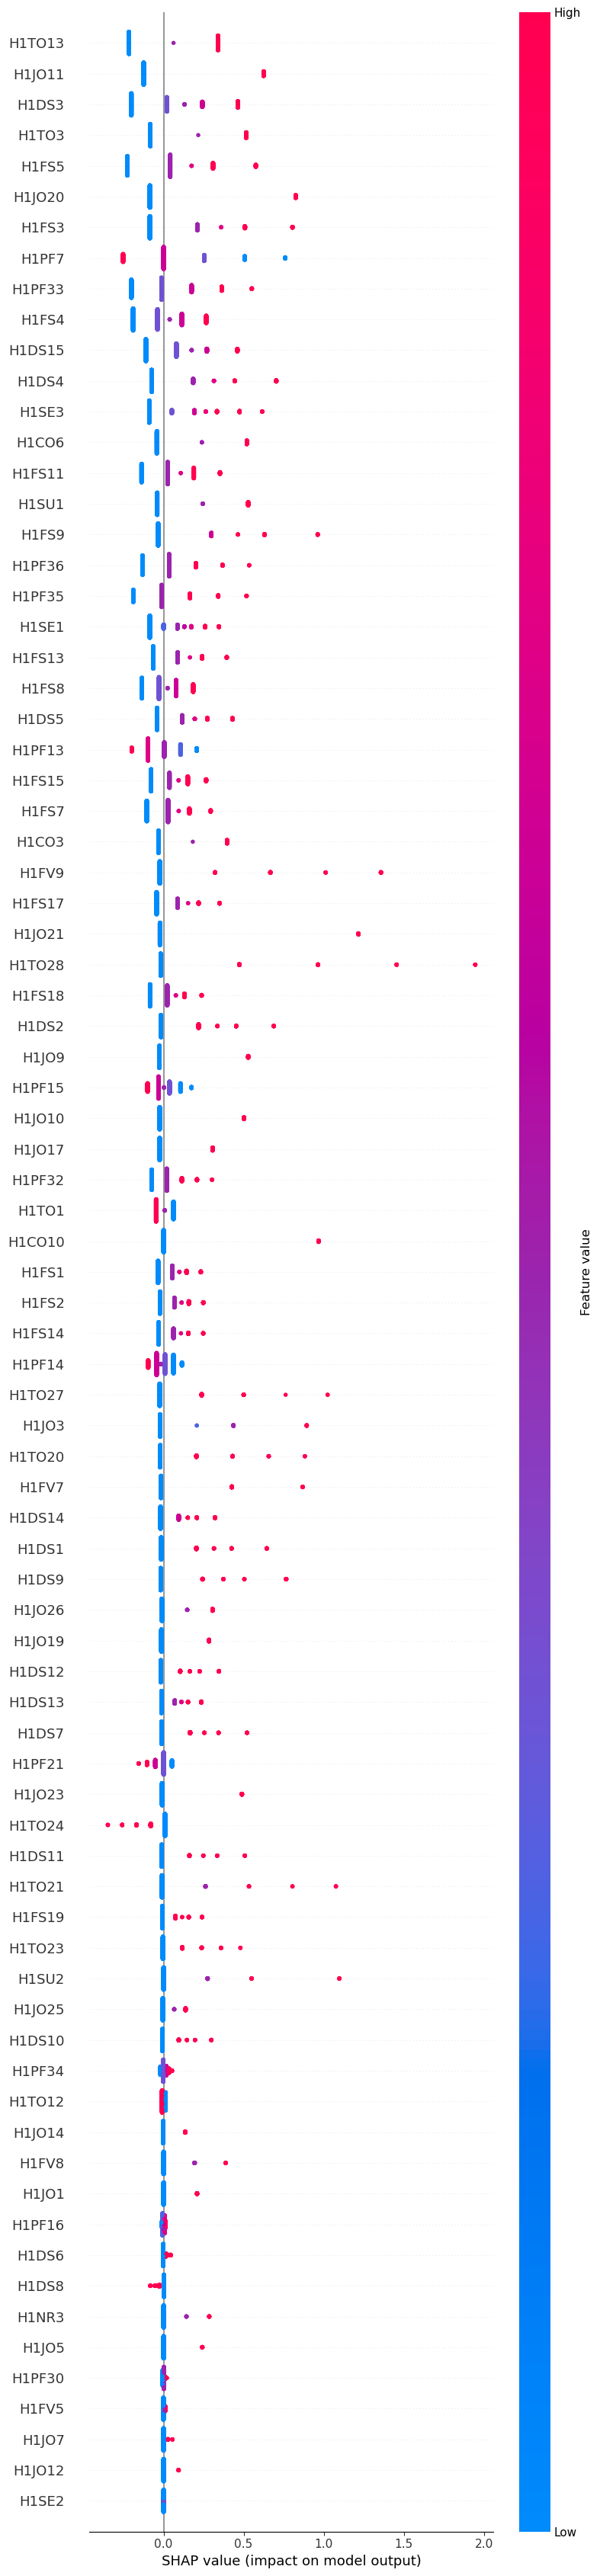

In [24]:
shap.summary_plot(shap_values_reshaped, X_test, max_display=X_test.shape[1])